In [53]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import pickle
import PIL as pillow
from tqdm import tqdm
import numpy as np
import seaborn as sns
import scipy.stats as spst
import scipy
from statannotations.Annotator import Annotator
import time
from pathlib import Path
import argparse
from matplotlib.gridspec import GridSpec
from matplotlib.transforms import Affine2D
import baisic_plot_fuctnions_and_features as bpf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [38]:
bpf.set_plot_properties()

vlinec = "#C35817"

learner_cell = "2022_12_21_cell_1" 
non_learner_cell = "2023_01_10_cell_1"
time_to_plot = 0.250 # in s 

time_points = ["pre","0", "10", "20","30" ]
selected_time_points = ['post_0', 'post_1', 'post_2', 'post_3','pre']
                        #'post_4','post_5']
cell_dist=[8,10,4]
cell_dist_key = ["leaners","non\nlearners","cells\nnot\ncosidered"]

In [3]:
curve_fit_data = pd.read_hdf("/Users/anzalks/Documents/pattern_learning_paper/plotting_scripts/python_scripts_paper_ready/analysis_scripts/pickle_files_from_analysis/curvefir_results.h5")

In [134]:
curve_fit_data.columns

Index(['cell_ID', 'pre_post_status', 'frame_type', 'Epk', 'Etau', 'Ipk',
       'Itau', 'delay', 'initDelay', 'score'],
      dtype='object')

In [6]:
cell_dict_classified = pd.read_pickle("/Users/anzalks/Documents/pattern_learning_paper/plotting_scripts/python_scripts_paper_ready/analysis_scripts/pickle_files_from_analysis/all_cells_fnorm_classifeied_dict.pickle")

In [12]:
learners = cell_dict_classified["ap_cells"].keys()
non_learners = cell_dict_classified["an_cells"].keys()

In [136]:
def norm_values(cell_list,val_to_plot):
    cell_list = cell_list.copy()
    #print(f"cell list inside func : {cell_list}")
    cell_grp=cell_list.groupby(by="cell_ID")
    for c, cell in cell_grp:
        pat_grp = cell.groupby(by="frame_type")
        for p,pat in pat_grp:
            if "pattern" not in p:
                continue
            else:
                #print(f"c:{c}, p:{p}")
                pre_val= float(cell[(cell["cell_ID"]==c)&(cell["frame_type"]==p)&(cell["pre_post_status"]=="pre")][val_to_plot])
                pp_grp = pat.groupby(by="pre_post_status")
                for pr, pp in pp_grp:
                    norm_val = float(cell[(cell["cell_ID"]==c)&(cell["frame_type"]==p)&(cell["pre_post_status"]==pr)][val_to_plot])
                    norm_val = (norm_val/pre_val)*100
                    cell_list.loc[(cell_list["cell_ID"]==c)&(cell_list["frame_type"]==p)&(cell_list["pre_post_status"]==pr),val_to_plot]=norm_val
    return cell_list
   
def plot_cell_dist(catcell_dist,val_to_plot,fig,axs,pattern_number,y_lim,
                   x_label, cell_type,plt_color,resp_color):
    pat_num=int(pattern_number.split("_")[-1])
    num_cells= len(catcell_dist["cell_ID"].unique())
    pfd = catcell_dist.groupby(by="frame_type")
    for c, pat in pfd:
        pat[f"{val_to_plot}"].where(pat[f"{val_to_plot}"] <1000, np.nan, inplace=True)
        if c != pattern_number:
            continue
        else:
            order = np.array(('pre','post_0','post_1','post_2','post_3'),dtype=object)
            g=sns.stripplot(data=pat, x="pre_post_status",y=f"{val_to_plot}",
                            order=order,ax=axs,color=resp_color,
                            alpha=0.6,size=8, label='cell response')#alpha=0.8,
            sns.pointplot(data=pat, x="pre_post_status",y=f"{val_to_plot}",
                          errorbar="se",order=order,capsize=0.08,ax=axs,
                          color=plt_color, linestyles='dotted',scale = 0.8,
                         label="average cell response")
            g.set_title(None)
            #"""
            pvalList = []
            anotp_list = []
            for i in order[1:]:
                posti ="post{i}"
                #non parametric, paired and small sample size, hence used Wilcoxon signed-rank test
                #Wilcoxon signed-rank test
                posti= spst.wilcoxon(pat[pat["pre_post_status"]=='pre'][f"{val_to_plot}"],pat[pat["pre_post_status"]==i][f"{val_to_plot}"],
                                     zero_method="wilcox", correction=True)
                pvalList.append(posti.pvalue)
                anotp_list.append(("pre",i))
            annotator = Annotator(axs,anotp_list,data=pat, 
                                  x="pre_post_status",
                                  y=f"{val_to_plot}",
                                  order=order,
                                 fontsize=8)
            #annotator = Annotator(axs[pat_num],[("pre","post_0"),("pre","post_1"),("pre","post_2"),("pre","post_3")],data=cell, x="pre_post_status",y=f"{col_pl}")
            annotator.set_custom_annotations([bpf.convert_pvalue_to_asterisks(a) for a in pvalList])
            annotator.annotate()
            #"""
            axs.axhline(100, ls=':',color="k", alpha=0.4)
            if pat_num==0:
                sns.despine(fig=None, ax=axs, top=True, right=True, 
                            left=False, bottom=False, offset=None, trim=False)
                axs.set_ylabel("% change in\nEPSP amplitude")
                axs.set_xlabel(None)
                #axs[pat_num].set_yticks([])
            elif pat_num==1:
                sns.despine(fig=None, ax=axs, top=True, right=True, 
                            left=False, bottom=False, offset=None, trim=False)
                axs.set_ylabel(None)
                axs.set_yticklabels([])
                if cell_type=="dep_cells":
                    axs.set_xlabel(x_label)
                else:
                    axs.set_xlabel(None)
            elif pat_num==2:
                sns.despine(fig=None, ax=axs, top=True, right=True, 
                            left=False, bottom=False, offset=None, trim=False)
                axs.set_xlabel(None)
                axs.set_ylabel(None)
                axs.set_yticklabels([])
            else:
                pass 
            g.set(ylim=y_lim)
            g.set_xticklabels(time_points,rotation=0)
            g.legend_.remove()
            if cell_type!="dep_cells":
                axs.set_xticklabels([])
            else:
                pass 


    ax_pos = axs.get_position()
    #new_ax_pos = [ax_pos.x0-0.02, ax_pos.y0, ax_pos.width,
    #              ax_pos.height]
    #axs.set_position(new_ax_pos)




def plot_cell_category_classified_EPSP_features(esp_feat_cells_df,val_to_plot,
                                                fig,axs1,axs2,axs3,cell_type):
    cell_df= norm_values(esp_feat_cells_df,val_to_plot)
    if cell_type=="pot_cells":
        strp_color = bpf.CB_color_cycle[0]
        line_color = bpf.CB_color_cycle[5]
        y_lim = (-100,800)
        x_label = None
    elif cell_type=="dep_cells":
        strp_color = bpf.CB_color_cycle[1]
        line_color = bpf.CB_color_cycle[5]
        y_lim = (-200,500)
        x_label = "time points (mins)"
    else:
        y_lim=None
        strp_color = bpf.CB_color_cycle[1]
        line_color = bpf.CB_color_cycle[5]
        x_label = "time points (mins)"
        print("uncagerised cell")
        
    plot_cell_dist(cell_df,val_to_plot,fig,axs1,"pattern_0",
                   y_lim,x_label,cell_type,line_color,strp_color
                  )
    plot_cell_dist(cell_df,val_to_plot,fig,axs2,"pattern_1",
                   y_lim,x_label,cell_type,line_color,strp_color
                  )
    plot_cell_dist(cell_df,val_to_plot,fig,axs3,"pattern_2",
                   y_lim,x_label,cell_type,line_color,strp_color
                  )

In [119]:
def classify_cells_curve_fit(cell_dict_classified,curve_fit_data):
    cell_grps =curve_fit_data.groupby(by="cell_ID")
    learners_list = cell_dict_classified["ap_cells"]["cell_ID"].unique()
    non_learners_list = cell_dict_classified["an_cells"]["cell_ID"].unique()
    #print(non_learners_list)
    learners=[]
    non_learners =[]
    for cell, cell_data in cell_grps:
        if cell in learners_list:
            cell_data["cell_ID"]=cell
            learners.append(cell_data)
            #print("learner", cell)
        elif cell in non_learners_list:
            cell_data["cell_ID"]=cell
            non_learners.append(cell_data)
            #print("non-learner", cell)
        else:
            pass
            #print("uncategorised")
    learners=pd.concat(learners)
    non_learners = pd.concat(non_learners)
    return learners, non_learners
    

In [120]:
learners,non_learners = classify_cells_curve_fit(cell_dict_classified,curve_fit_data)

In [115]:
learners["cell_ID"].unique()

array(['2022_12_12_cell_5', '2022_12_21_cell_1', '2023_01_09_cell_2',
       '2023_01_09_cell_3', '2023_01_27_cell_1', '2023_02_24_cell_3',
       '2023_02_26_cell_1'], dtype=object)

In [140]:
def plot_feature_from_curve_fit(feature_to_plot):
    learners,non_learners = classify_cells_curve_fit(cell_dict_classified,curve_fit_data)
    fig = plt.figure()
    #plot patterns
    axs1 = fig.add_subplot(131)
    axs2 = fig.add_subplot(132)
    axs3 = fig.add_subplot(133)

    plot_cell_category_classified_EPSP_features(learners,feature_to_plot,fig,axs1,axs2,axs3,"pot_cells")

    axs2.set_title(f"learners: {feature_to_plot}")
    plt.show()
    plt.close(fig)
    
    fig = plt.figure()
    #plot patterns
    axs1 = fig.add_subplot(131)
    axs2 = fig.add_subplot(132)
    axs3 = fig.add_subplot(133)
    
    plot_cell_category_classified_EPSP_features(non_learners,feature_to_plot,fig,axs1,axs2,axs3,"dep_cells")
    
    axs2.set_title(f"non-learners: {feature_to_plot}")
    plt.show()
    plt.close(fig)


In [151]:
features_to_plot = list(curve_fit_data.columns)[3:-1]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: *
pre vs. post_1: *
pre vs. post_2: *
pre vs. post_3: *
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: *
pre vs. post_1: ns
pre vs. post_2: *
pre vs. post_3: *
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


pre vs. post_2: ns
pre vs. post_3: ns


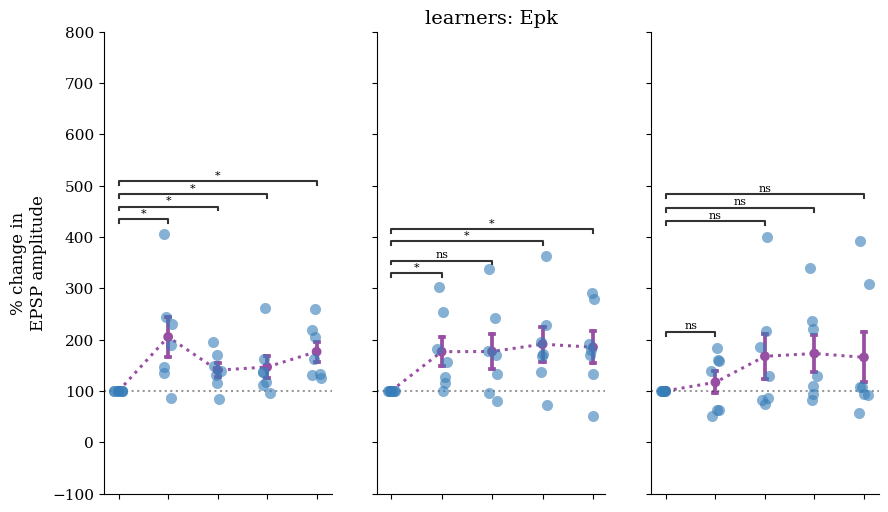

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: **
pre vs. post_3: ***
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: *
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


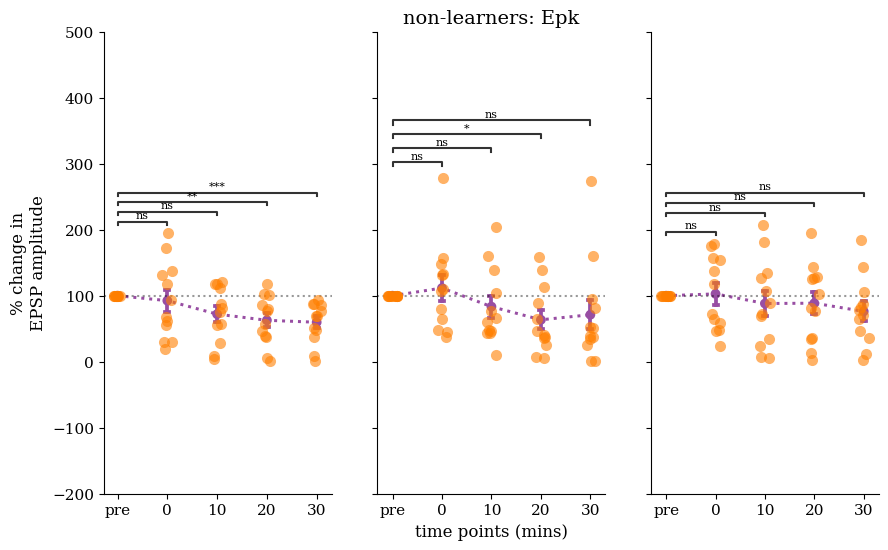

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: *
pre vs. post_1: ns
pre vs. post_2: *
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


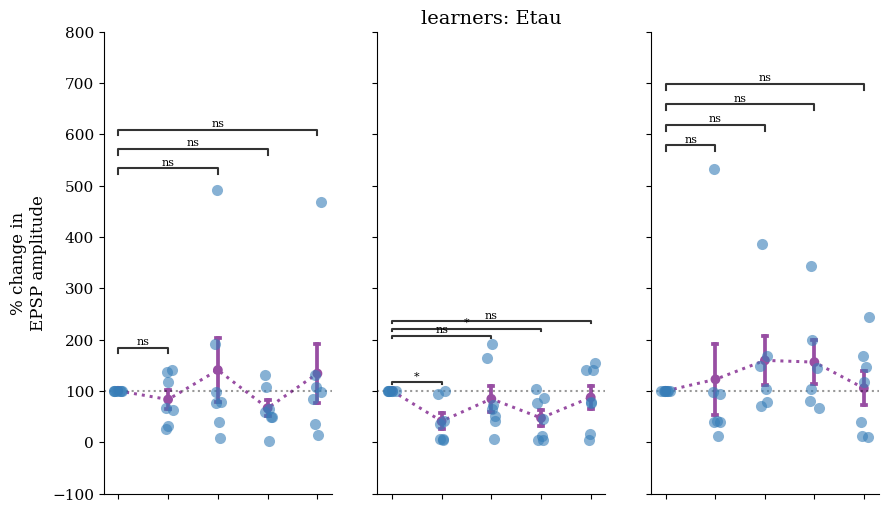

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: *
pre vs. post_3: **
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: *
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


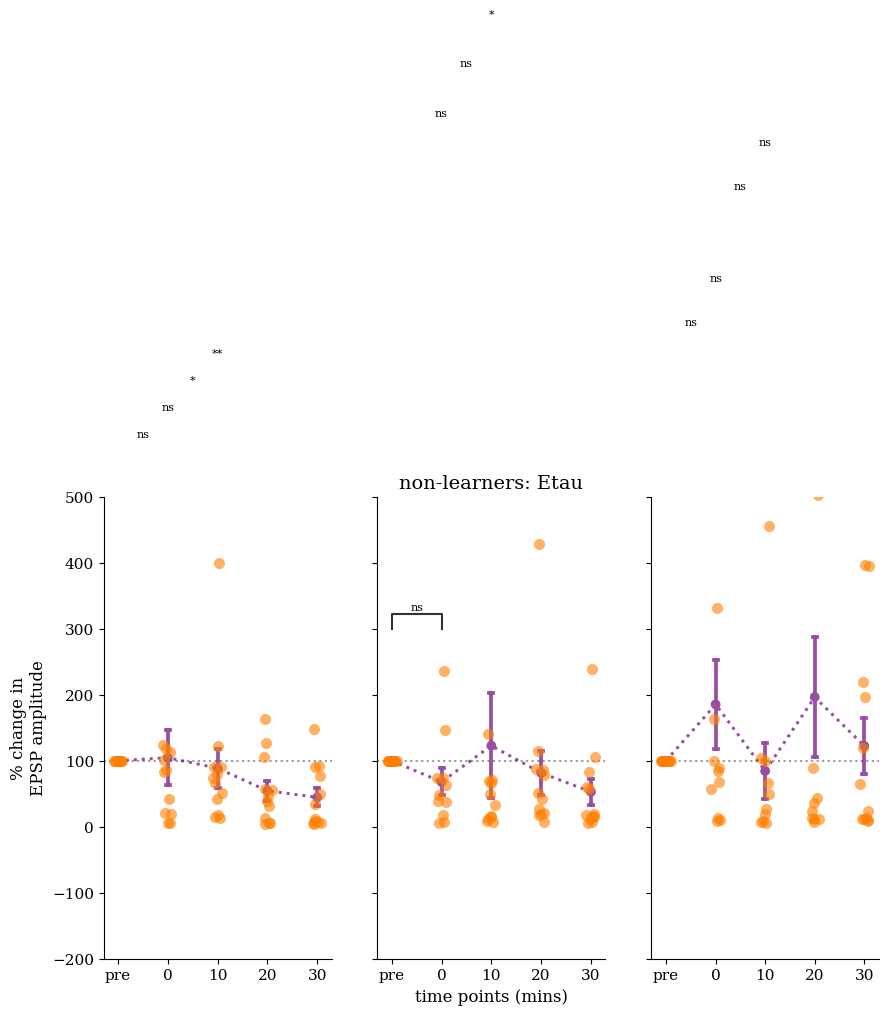

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: *
pre vs. post_2: *
pre vs. post_3: *


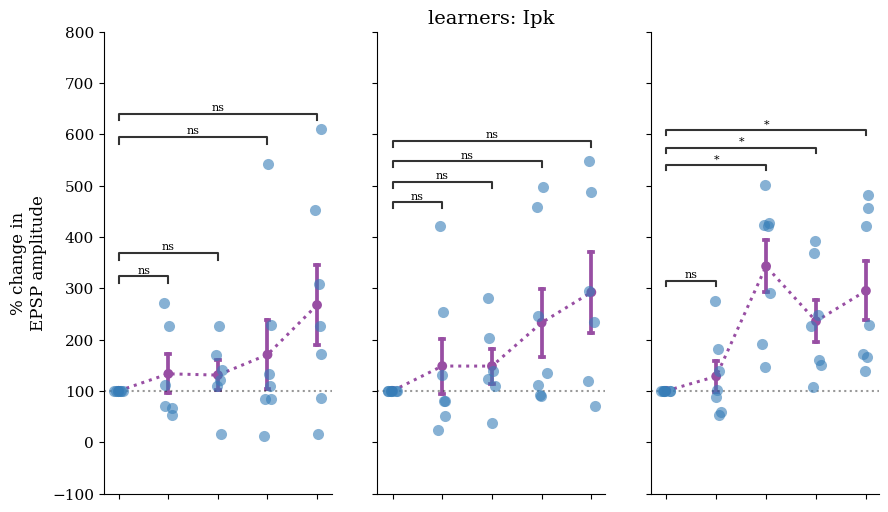

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: *
pre vs. post_3: *


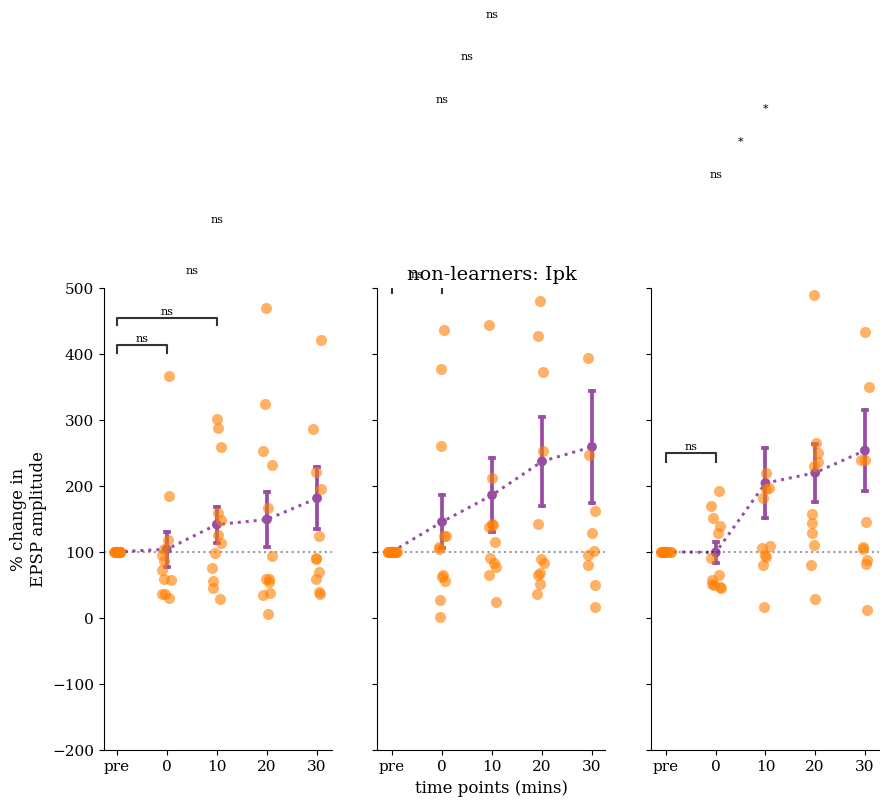

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: *
pre vs. post_3: ns


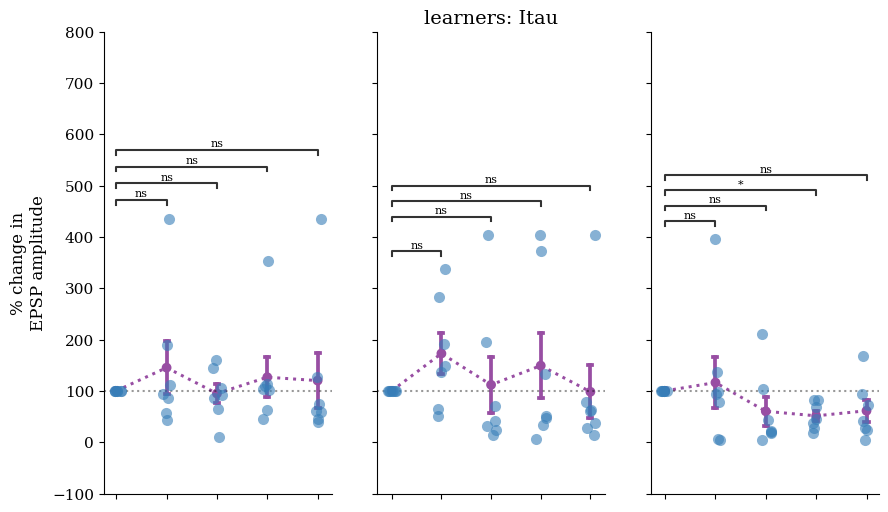

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: *
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: **
pre vs. post_3: ***
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


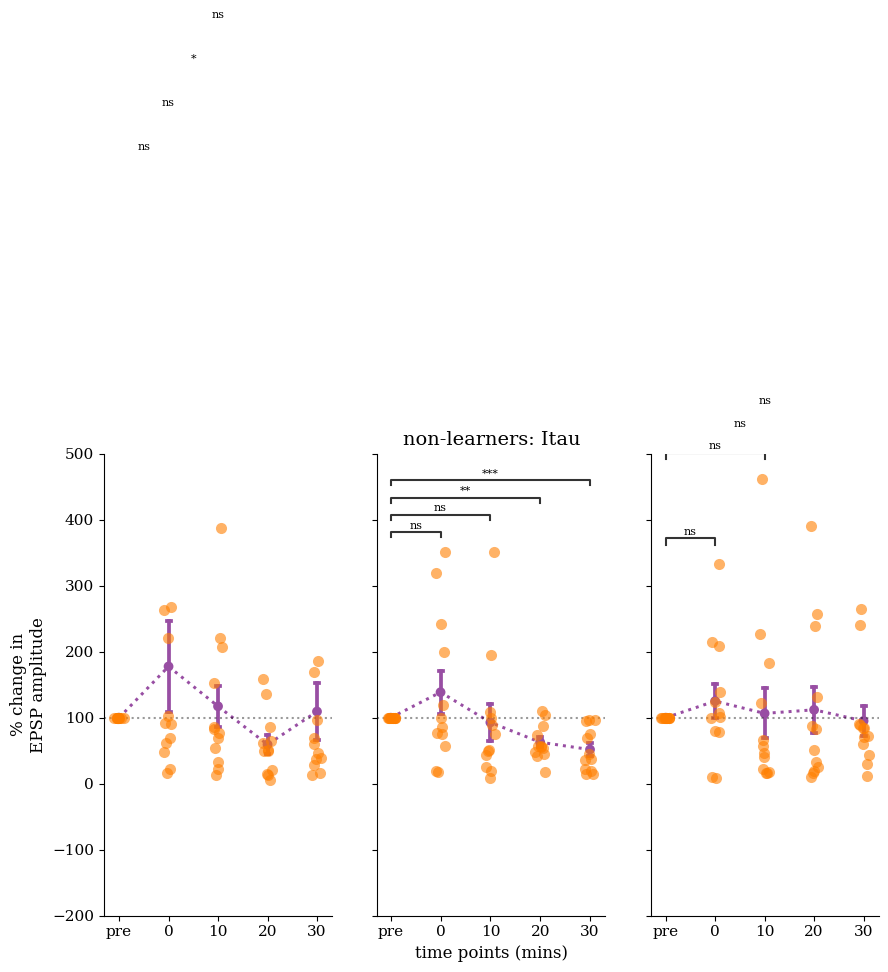

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


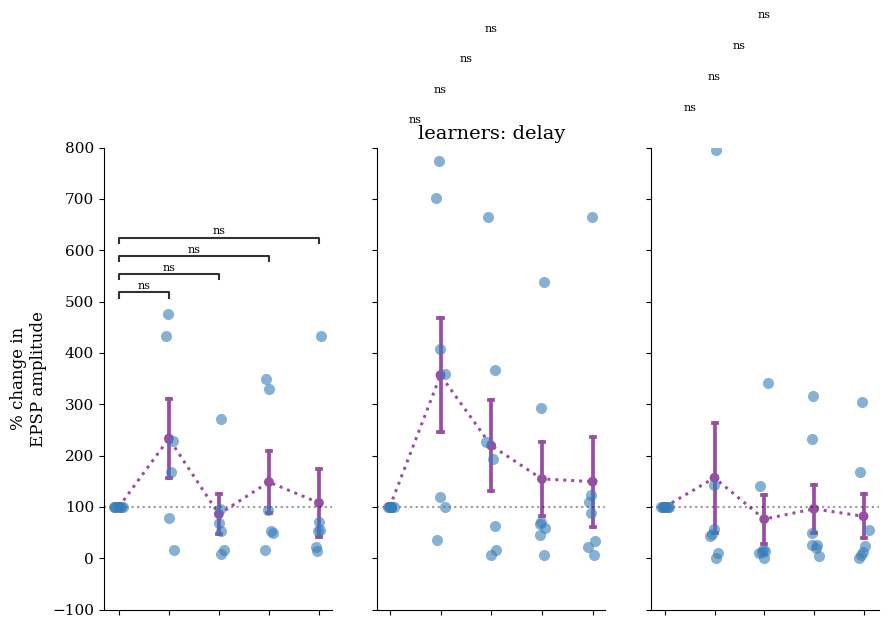

/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: **
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


pre vs. post_1: *
pre vs. post_2: ns
pre vs. post_3: ns


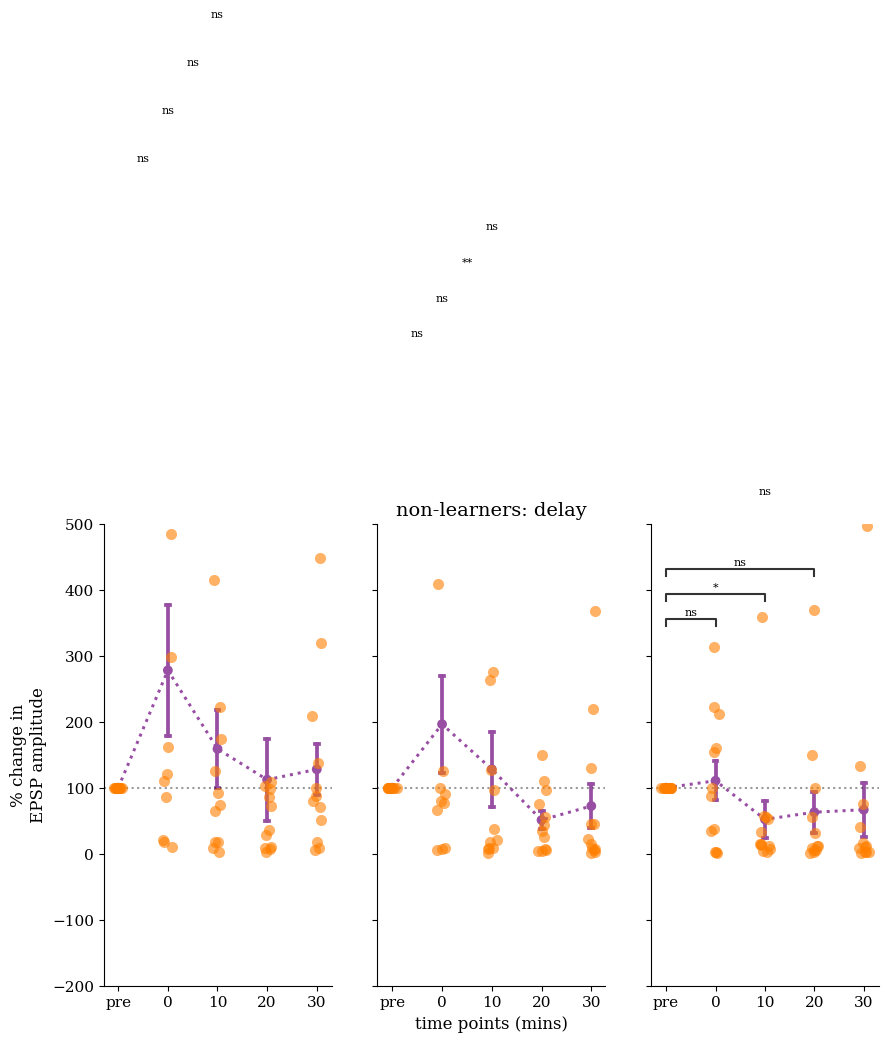

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


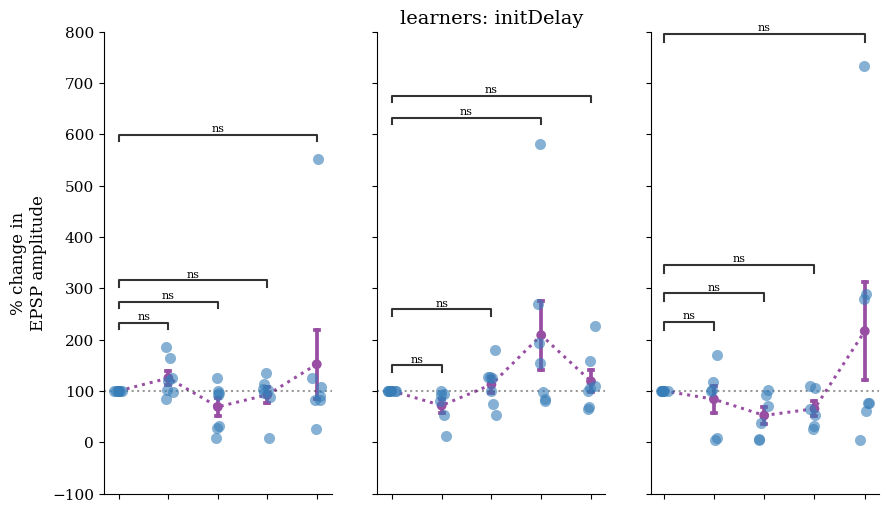

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/anzalks/miniconda3/envs/lab_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post_0: ns
pre vs. post_1: ns
pre vs. post_2: ns
pre vs. post_3: ns


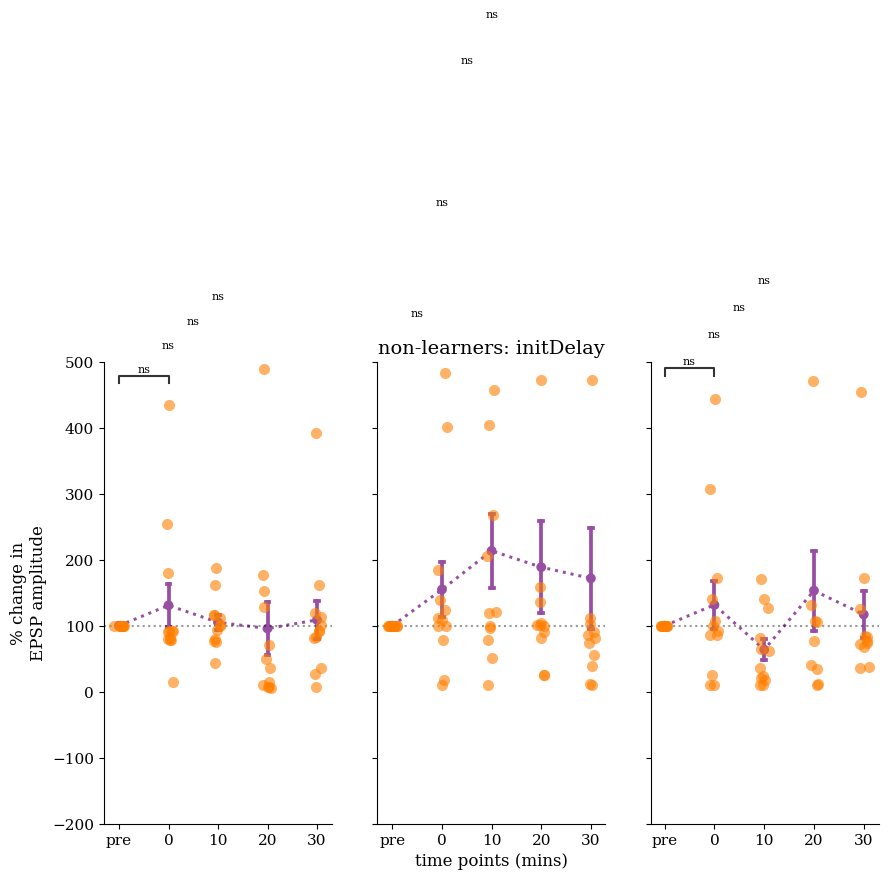

In [153]:
for feature in features_to_plot:
    plot_feature_from_curve_fit(feature)